This is a binary classification problem, since we're predicting if the patient develops Sepssis or not.

# Exploratory Data Analysis


In [95]:
# importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from matplotlib import pyplot as plt

data = pd.read_csv('./Paitients_Files_Train.csv')
data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


Now that the data is loaded, all columns can be seen. ID and Insurance are variables that don't have a direct health impact on a patient, and hence can be removed. Let's describe the data next.

In [96]:
data.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In this description we can see important statistics about each numerical variable in the data including the mean and the standard deviation. Next let's find out how many unique values each variable has.

In [97]:
# How many unique values does a column have
data.nunique()

ID           599
PRG           17
PL           129
PR            44
SK            51
TS           164
M11          233
BD2          437
Age           50
Insurance      2
Sepssis        2
dtype: int64

We can see that some variables take more unique values than others. It's also nice to note that we don't have any categorical variables (including sepssis, which is a essentially binary variable).

Now I'll check if the data contains any null values

In [98]:
data.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

There are no null values in the dataset; which is good. However, I did notice a few values that were zero. This might actually represent a null value that was substituted with zero. It would be interesting to eventually develop a separate model which treats these values as null and compare the results. I have, however, not done that for this assignment.

# Data preparation
Now I'll remove the Insurance and ID fields from the data as they don't affect the Sepssis prediction.

In [99]:
patients_raw = data.drop(['Insurance', 'ID'], axis = 1)

patients_raw.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,Positive
1,1,85,66,29,0,26.6,0.351,31,Negative
2,8,183,64,0,0,23.3,0.672,32,Positive
3,1,89,66,23,94,28.1,0.167,21,Negative
4,0,137,40,35,168,43.1,2.288,33,Positive


First, I'll convert the sepssis column into a binary numeric value.

In [100]:
patient_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Sepssis']

# replace Sepssis column with a binary numeric value

patients = patients_raw.copy(deep=True)
with pd.option_context('mode.chained_assignment', None):
	patients['Sepssis'][patients['Sepssis'] == 'Positive'] = 1
	patients['Sepssis'][patients['Sepssis'] == 'Negative'] = 0

patients.head(5)

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Relationship analysis

Next, let's find out the distribution of our "y" or dependent variable.

<AxesSubplot:xlabel='Sepssis', ylabel='count'>

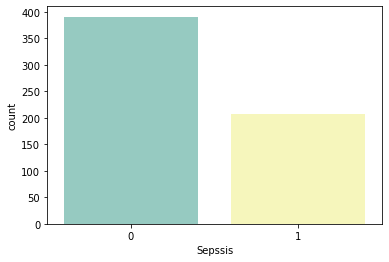

In [101]:
sns.countplot(x = 'Sepssis', data = patients, palette = 'Set3')

We can see with this that most of the patients do not develop Sepssis in the ICU. This is actually a problem as this means that we can't rely solely on our accuracy score metric; we need to use a confusion matrix to see how many false positives and false negatives our model generates.

This is a common problem in binary classification, because the model will perform a lot better in predicting the majority class (in this case Sepssis negative) and not so much for the minority class (Sepssis positive), which is arguably the whole point of the model.

There are multiple propsoed ways to deal with this in the literature, including data under-sampling and data over-sampling, each 
with its advantages and disadvantages. (Boyle 2019) (‘How to Handle Imbalanced Classes in Machine Learning’ 2019)

### Solution
Because I'm inclined to use a logistic regression model, which is typically worse at handling imbalanced data when compared to, for example, Decison Trees, I opted to use the Synthetic Minority Oversampling Technique (SMOTE) (‘Imbalanced Classification | Handling Imbalanced Data using Python’ 2020).

This technique essentially generates synthetic data for the minority class by using the help of interpolation between the positive instances of the class.

### Dsiadvantage
The downside of this technique is that it might lead to overfitting. In this case, the imbalance isn't extreme, however, I'll attempt to counetract the risk by risk by tuning my model's hyper prameters.

<AxesSubplot:xlabel='Sepssis', ylabel='count'>

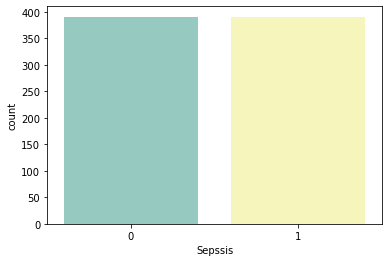

In [102]:
# implement the SMOTE technique
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE


overampler = SMOTE()

patients_x = patients.drop(['Sepssis',], axis=1)
patients_y = patients[['Sepssis']].astype('int').Sepssis

patients_x, patients_y = overampler.fit_resample(patients_x, patients_y)


patients = patients_x
patients['Sepssis'] = patients_y

sns.countplot(x = 'Sepssis', data = patients, palette = 'Set3')

Now the dataset is balanced 😁

Next, let's explore the relationships between the variables.

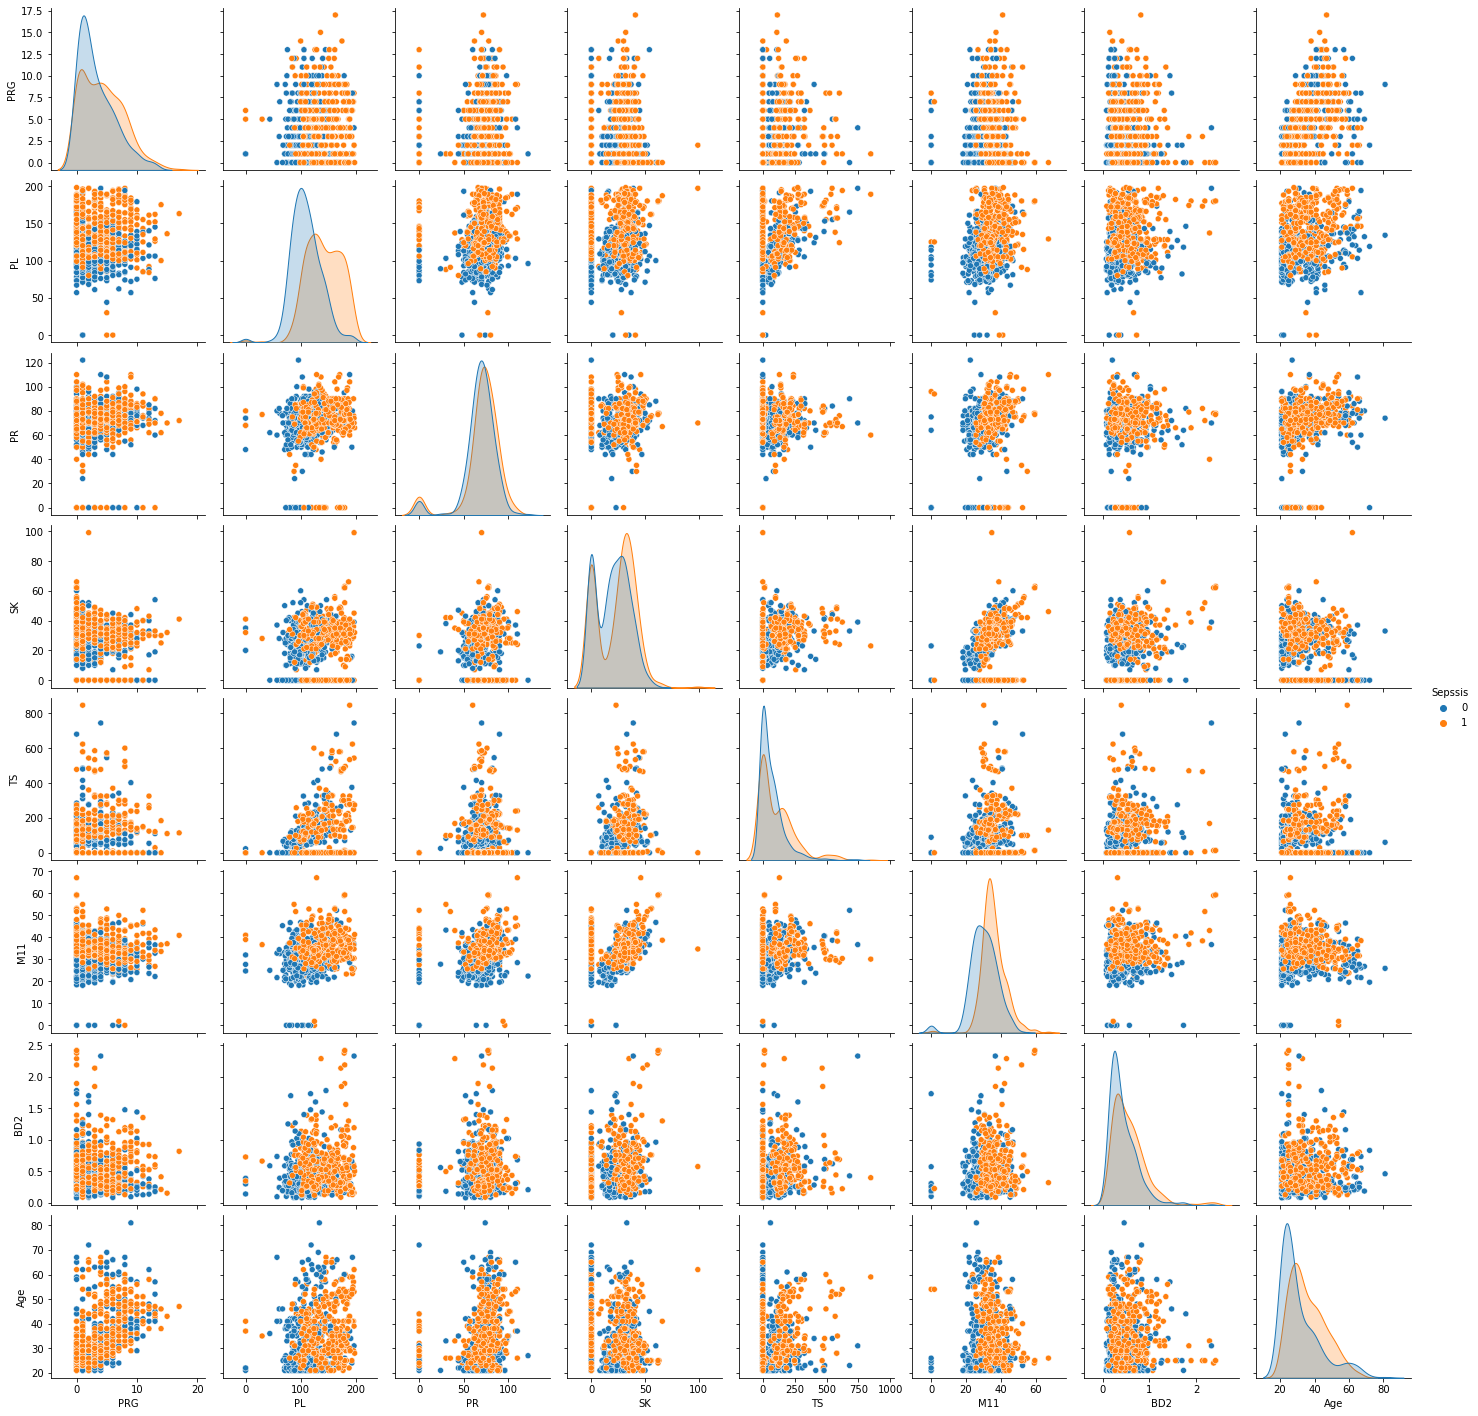

In [103]:
sns.pairplot(patients, hue='Sepssis')

These pairplots show how each of the variables exist in relation to the other variables, with the hue being the Sepssis status of the patient.

This is very informative as we can see some variables have a higher correlation with one another, as well as a visible's tendency to impact the Sepssis status of the patient.

<AxesSubplot:>

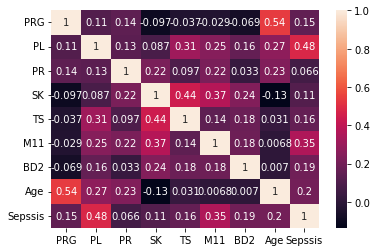

In [104]:
correlation = patients.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

This heatmap is very telling as we can see that PRG has a high correlation with age.

Also, PR has a correlation with M11.

And SK has a high correlation with TS and M11

And TS has a correlation with BD2

# Model selection

In light of the exploratory data analysis, I decided to build a logistic regression model. This is because all the independent variables in the dataset are numeric, and logistic regression works well with such datasets.

Looking at the pair plot, important variables, while not exactly linearly separable, are roughly linearly separable. Using hyper parameter tuning and weighted classes, I hypothesize that a logistic regression model will work well.

While a decision tree or a Random Forest implementation of multiple decision trees might also have been a good choice, I propose that a logistic regression model with weighted classes will be a good choice in this case.

# Building the model
First, I split the data into a training and validation set with 20% of the data kept for validation, and 80% for training the model.

In [105]:
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(patients, test_size=0.2, shuffle=True, random_state=0)

In [106]:
train_x = train_data.drop(['Sepssis',], axis=1).to_numpy()
train_y = train_data[['Sepssis']].to_numpy().astype('int')

val_x = val_data.drop(['Sepssis',], axis=1).to_numpy()
val_y = val_data[['Sepssis']].to_numpy().astype('int')

# Evaluation framework

Let's set up an evaluation framework to test how good our model is

### Accuracy scores

In [107]:
classifier = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)
classifier.fit(train_x, train_y.ravel())

# print_accuracy_scores(classifier, train_x, train_y, val_x, val_y)
y_pred = classifier.predict(train_x)
val_pred = classifier.predict(val_x)

# used later for the log loss function
predicted_probabilities_train = classifier.predict_proba(train_x)
predicted_probabilities_val = classifier.predict_proba(val_x)

train_accuracy = metrics.accuracy_score(train_y, y_pred)
val_accuracy = metrics.accuracy_score(val_y, val_pred)

print("Train Accuracy score: {:.3f}".format(train_accuracy))
print("Validation Accuracy score: {:.3f}".format(val_accuracy))
print(metrics.classification_report(train_y, y_pred))

Train Accuracy score: 0.738
Validation Accuracy score: 0.745
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       316
           1       0.75      0.70      0.72       309

    accuracy                           0.74       625
   macro avg       0.74      0.74      0.74       625
weighted avg       0.74      0.74      0.74       625



### Confusion matrix function

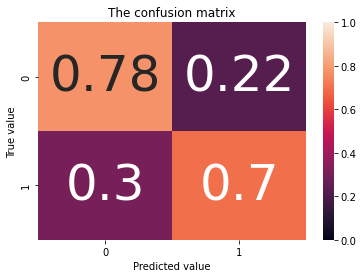

In [108]:
# Confusion matrix

def show_confusion_matrix(cm, classes=None, title='The confusion matrix'):
	if classes is not None:
		sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmax=1., vmin=0., annot=True, annot_kws={'size': 50})
	else:
		sns.heatmap(cm, vmin=0., vmax=1.)

	plt.title(title)
	plt.ylabel('True value')
	plt.xlabel('Predicted value')


#Visualize the matrix

cm = metrics.confusion_matrix(train_y, y_pred)
cm_normalized = cm / cm.sum(axis=1).reshape(-1, 1)

show_confusion_matrix(cm_normalized, classes=classifier.classes_)

When the true Sepssis value was positive, we predicted it correctly about 71% of the time.
When the true value for Sepssis was negative, we predicted it correctly about 76% of the time.

### Logarithmic loss function

In [109]:
#Log loss function
print("The log loss on the training data: ", metrics.log_loss(train_y, predicted_probabilities_train))
print("The log loss on the validation data: ", metrics.log_loss(val_y, predicted_probabilities_val))


The log loss on the training data:  0.5208304010642759
The log loss on the validation data:  0.4950970858890258


# Hyper parameter tuning

To tune the C value for this model, instead of looping through C values manually and comparing accuracy and logarithmic loss scores, I'll use the built-in LogisticRegressionCV model which has cross-validation built-in.

Instead of hold-out validationm, I've opted for K-fold cross-validation, which will use all the training data in the model by applying k different splits. Repeated train-test splits will be used. The disadvantage of this approach is that we won't be able to see how our model performs on completely unseen data, but that's okay because we get to use the entire dataset for training.

Train Accuracy score: 0.754
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       391
           1       0.77      0.73      0.75       391

    accuracy                           0.75       782
   macro avg       0.75      0.75      0.75       782
weighted avg       0.75      0.75      0.75       782

The log loss on the training data:  0.5017667476222358
The optimal C parameter identified using cross validation is [3.59381366]


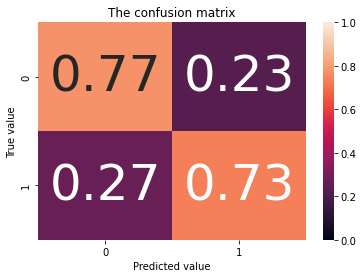

In [112]:
C_List = np.geomspace(1e-5, 1e5, num=100)
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
classifier2 = LogisticRegressionCV(random_state=0, solver='liblinear', max_iter=1000, cv=kfold, Cs=C_List, class_weight='balanced')

train_x_2 = patients.drop('Sepssis', axis=1)
train_y_2 = patients['Sepssis']

classifier2.fit(train_x_2, train_y_2);


# print_accuracy_scores(classifier, train_x, train_y, val_x, val_y)
y_pred_2 = classifier2.predict(train_x_2)

# used later for the log loss function
predicted_probabilities_train = classifier2.predict_proba(train_x_2)

train_accuracy = metrics.accuracy_score(train_y_2, y_pred_2)

print("Train Accuracy score: {:.3f}".format(train_accuracy))
print(metrics.classification_report(train_y_2, y_pred_2))


print("The log loss on the training data: ", metrics.log_loss(train_y_2, predicted_probabilities_train))

cm = metrics.confusion_matrix(train_y_2, y_pred_2)
cm_normalized = cm / cm.sum(axis=1).reshape(-1, 1)

show_confusion_matrix(cm_normalized, classes=classifier2.classes_)
print("The optimal C parameter identified using cross validation is {}".format(classifier2.C_))

# Final model

In [120]:
final_classifier = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, C=3.59381366, class_weight='balanced')

final_classifier.fit(train_x, train_y.ravel())

#predicted probabilities and metrics on unseen validation data
predicted_probability_final = final_classifier.predict_proba(val_x)
log_loss_final = metrics.log_loss(val_y, predicted_probability_final)

final_classifier_score = final_classifier.score(val_x, val_y)

print("Accuracy on validation data: ", final_classifier_score)
print("Log loss: ", log_loss_final)

cm = metrics.confusion_matrix(train_y_2, y_pred_2)
cm_normalized = cm / cm.sum(axis=1).reshape(-1, 1)

show_confusion_matrix(cm_normalized, classes=classifier2.classes_)
print("The optimal C parameter identified using cross validation is {}".format(classifier2.C_))


Accuracy on validation data:  0.7707006369426752
Log loss:  0.46633857297701564


# Testing the model on unseen data

In [111]:
data_unseen = pd.read_csv('./Paitients_Files_Test.csv')
data_unseen.shape

(169, 10)

# References
Reference list Boyle, T 2019, ‘Methods for Dealing with Imbalanced Data’, Medium, viewed <https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18>

‘How to Handle Imbalanced Classes in Machine Learning’ 2019, EliteDataScience, viewed <https://elitedatascience.com/imbalanced-classes>

‘Imbalanced Classification | Handling Imbalanced Data using Python’ 2020, Analytics Vidhya, viewed <https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/>.